In [63]:
from pyimzml.ImzMLParser import ImzMLParser, browse, getionimage
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import pytraj as pt
%matplotlib inline

In [64]:
parser = ImzMLParser("/usr/local/hdd/rita/msimaging/181114_AT1_Slide_D_Proteins.imzML")

In [3]:
def tupel2map(spec):
    return dict(zip(spec[0], spec[1]))

In [4]:
def get_peaks(spec):
    interval = 100#len(spec.keys())//1000
       
    peaks = set()
    
    for intens in pt.tools.n_grams(list(spec.keys()), interval):
        maxI = 0
        maxMZ = 0
        
        epshull = (max(intens)-min(intens))/2
        
        for mz in intens:
            if spec[mz] > maxI:
                maxI = spec[mz]
                maxMZ = mz
        
        tmp = maxMZ
        
        addPeak = True
        if len(peaks) > 0:
            
            #exist already registered peak within epsilon hull with lower intensity?
            for p in peaks:
                
                if abs(p-tmp) < epshull:
                    if spec[p] < spec[tmp]:
                        peaks.remove(p)
                        peaks.add(tmp)
                        addPeak = False
                        break
                    else:
                        
                        addPeak = False
                        break
                        
        if addPeak:
            
            allValues = [spec[mz] for mz in intens]
            if maxI > 5*np.median(allValues):
                peaks.add(tmp)
            
    return np.array(list(peaks))

In [552]:
MY_TEST = 50
#MY_TEST = 12708

In [553]:
map2 = tupel2map(parser.getspectrum(MY_TEST))
print(len(map2))

17900


In [554]:
peaks2 = get_peaks(map2)

In [555]:
peaks2, len(peaks2)

(array([ 3456.38354413,  6273.9352534 ,  6018.89174035, ...,
         6646.6911571 ,  3325.08895457, 14975.59736143]), 23)

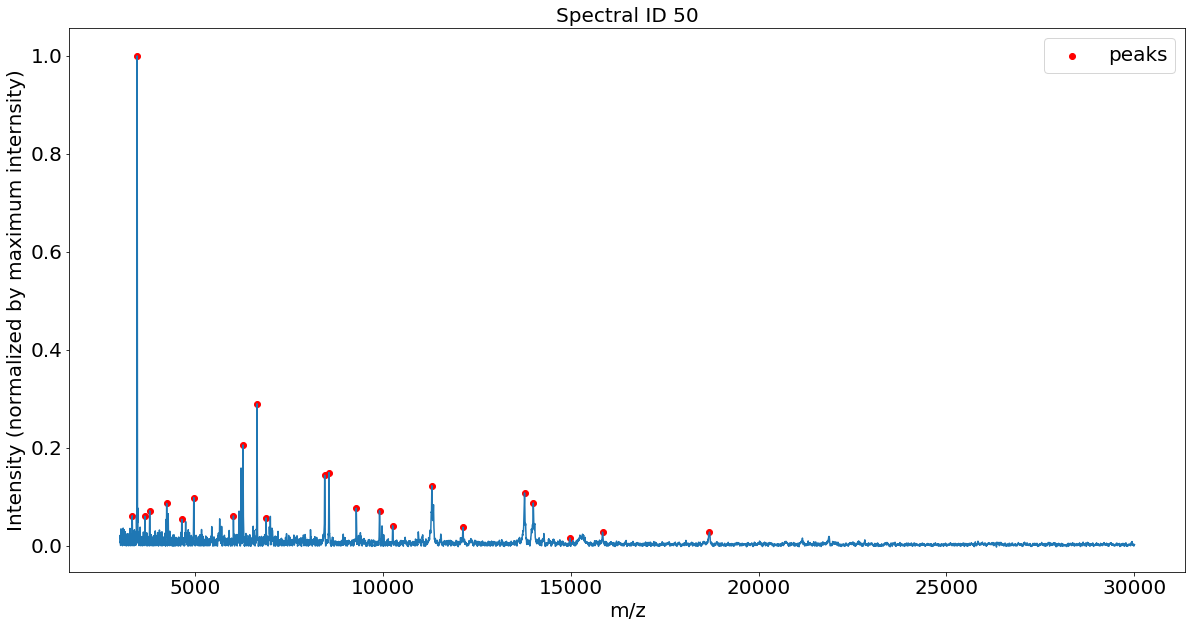

In [556]:
plt.figure(figsize=(20,10))
lists = map2.items()

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x,y/max(y))

values = [map2[x] for x in peaks2]
plt.scatter(list(peaks2), values/max(y), c='red', label='peaks')
plt.title("Spectral ID {}".format(MY_TEST), fontsize=20)
plt.xlabel("m/z", fontsize=20)
plt.ylabel("Intensity (normalized by maximum internsity)", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("peaksPexample2.png")

In [521]:
def similarity(spec1, spec2):
    map_1 = tupel2map(parser.getspectrum(spec1))
    map_2 = tupel2map(parser.getspectrum(spec2))
    '''
    #Similarity (dot product) of two comlpete spectra
    a = np.array(list(map_1.values()))
    a = a.reshape(1, len(a))
    b = np.array(list(map_2.values()))
    b = b.reshape(1, len(b))
    cos_lib = cosine_similarity(a, b)
    return cos_lib[0][0]
    #print("Two comlpete spectra ", cos_lib)
    '''
    peaks_spec1 = get_peaks(map_1)
    peaks_spec2 = get_peaks(map_2)
    
    mz = list(set().union(peaks_spec1, peaks_spec2))
    
    mz2int1 = [map_1[x] for x in mz]
    mz2int2 = [map_2[x] for x in mz]
    
    #Similarity (dot product) of two united peak-spectra
    a = np.array(mz2int1)
    b = np.array(mz2int2)  
    
    a = a.reshape(1, len(a))
    b = b.reshape(1, len(b))
    cos_lib = cosine_similarity(a, b)
    #print("Two united peak-spectra ",cos_lib)
    return(cos_lib[0][0])
    '''
    #Plots---------
    fig = plt.figure(figsize=(20, 25))
    fig.add_subplot(3,1,1)
    lists = map_1.items()

    x, y = zip(*lists) # unpack a list of pairs into two tuples

    plt.plot(x, y)

    values = [map_1[x] for x in peaks_spec1]
    plt.scatter(peaks_spec1, values, c='red')
    plt.title(spec1)

    fig.add_subplot(3,1,2)
    lists = map_2.items()

    x, y = zip(*lists) # unpack a list of pairs into two tuples

    plt.plot(x, y)
    
    values = [map_2[x] for x in peaks_spec2]
    plt.scatter(peaks_spec2, values, c='red')
    plt.title(spec2)
    
    fig.add_subplot(3,1,3)
    plt.imshow(getionimage(parser, max(map_1, key=map_1.get)))
    plt.colorbar()
    plt.tight_layout();
    #Plots------
    '''

In [610]:
def distance(spec1, spec2):
    map_1 = tupel2map(parser.getspectrum(spec1))
    map_2 = tupel2map(parser.getspectrum(spec2))
    
    peaks_spec1 = get_peaks(map_1)
    peaks_spec2 = get_peaks(map_2)
    
    mz = list(set().union(peaks_spec1, peaks_spec2))
    
    mz2int1 = [map_1[x] for x in mz]
    mz2int2 = [map_2[x] for x in mz]
    
    intens1 = np.array(mz2int1)
    intens2 = np.array(mz2int2)
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    return (np.sum(abs(intens1-intens2)))/intens1.shape[0]

In [611]:
distance(10000, 50)

0.14791380350390151

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

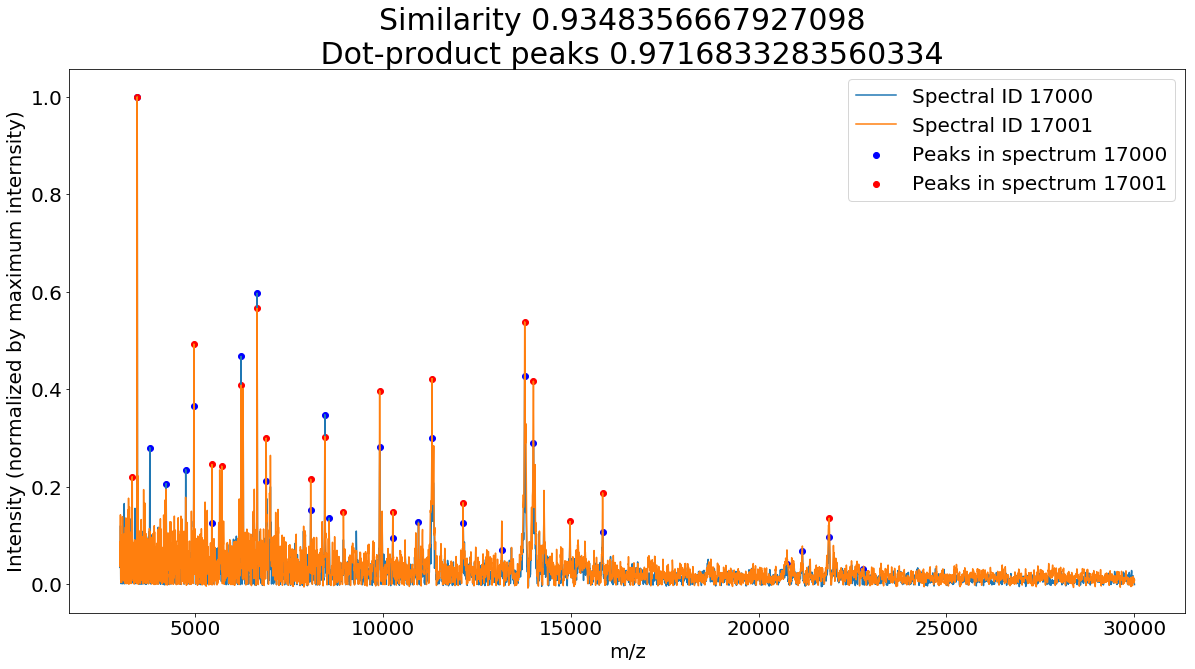

In [646]:
id1 = 17000
id2 = 17
mapid1 = tupel2map(parser.getspectrum(id1))
mapid2 = tupel2map(parser.getspectrum(id2))
peaksid1 = get_peaks(mapid1)
peaksid2 = get_peaks(mapid2)

plt.figure(figsize=(20,10))
lists = mapid1.items()
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x,y/max(y), label="Spectral ID {}".format(id1))
values = [mapid1[x] for x in peaksid1]
plt.scatter(list(peaksid1), values/max(y), c='blue', label='Peaks in spectrum {}'.format(id1))


lists = mapid2.items()
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x,y/max(y), label="Spectral ID {}".format(id2))
values = [mapid2[x] for x in peaksid2]
plt.scatter(list(peaksid2), values/max(y), c='red', label='Peaks in spectrum {}'.format(id2))
plt.title("Similarity {} \n Dot-product peaks {}".format(1-distance(id1, id2), similarity(id1, id2)), fontsize=30)
plt.xlabel("m/z", fontsize=20)
plt.ylabel("Intensity (normalized by maximum internsity)", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [651]:
intensities = list()
for x in range(617,  665):
    for y in range(210, 265):
        try:
            idx = parser.coordinates.index((x, y, 1))
            spec_map = tupel2map(parser.getspectrum(idx))
            to_add = list(spec_map.values())
            intensities.extend(to_add)
        except:
            print(f"({x}, {y}, 1) is not in list.")
print(len(intensities))

(617, 210, 1) is not in list.
(617, 211, 1) is not in list.
(617, 212, 1) is not in list.
(617, 213, 1) is not in list.
(617, 214, 1) is not in list.
(617, 215, 1) is not in list.
(617, 216, 1) is not in list.
(617, 217, 1) is not in list.
(617, 218, 1) is not in list.
(617, 219, 1) is not in list.
(617, 220, 1) is not in list.
(617, 221, 1) is not in list.
(617, 222, 1) is not in list.
(617, 223, 1) is not in list.
(617, 224, 1) is not in list.
(617, 225, 1) is not in list.
(617, 226, 1) is not in list.
(617, 227, 1) is not in list.
(617, 228, 1) is not in list.
(617, 229, 1) is not in list.
(617, 230, 1) is not in list.
(617, 231, 1) is not in list.
(617, 232, 1) is not in list.
(617, 233, 1) is not in list.
(617, 234, 1) is not in list.
(617, 235, 1) is not in list.
(617, 236, 1) is not in list.
(617, 237, 1) is not in list.
(617, 238, 1) is not in list.
(617, 239, 1) is not in list.
(617, 240, 1) is not in list.
(617, 241, 1) is not in list.
(617, 242, 1) is not in list.
(617, 243,

In [653]:
pintensities=sorted(intensities)/np.max(intensities)

184373


(array([0.03706616, 0.07285232, 0.10626285, ..., 0.99999458, 0.99999458,
        1.        ]),
 array([0.05000009, 0.05095009, 0.05190009, ..., 0.9981    , 0.99905   ,
        1.        ]),
 <a list of 1 Patch objects>)

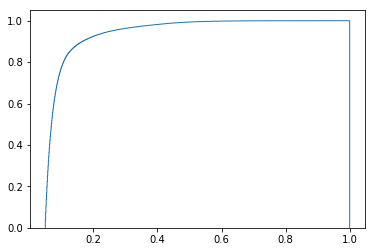

In [659]:
#|intensities = np.cumsum(intensities/np.max(intensities))
gpintensities = [x for x in pintensities if x > 0.05]

print(len(gpintensities))

plt.hist(gpintensities,bins=1000,density=True,cumulative=True,histtype='step')

In [661]:
184373/3
print(gpintensities[61457])
print(gpintensities[2*61457])

0.06094517784716186
0.08394087860919387


In [643]:
intensities

array([-1.41550305e-03, -2.64500030e-03, -3.84567462e-03, ...,
        1.69755743e+05,  1.69756663e+05,  1.69757663e+05])

(array([4.5386777e+07, 2.9348000e+04, 7.1740000e+03, 3.5200000e+03,
        2.1910000e+03, 8.3300000e+02, 2.7000000e+02, 6.8000000e+01,
        1.7000000e+01, 2.0000000e+00]),
 array([ -0.28025472,  19.54671942,  39.37369356, ..., 158.33553841,
        178.16251255, 197.98948669]),
 <a list of 10 Patch objects>)

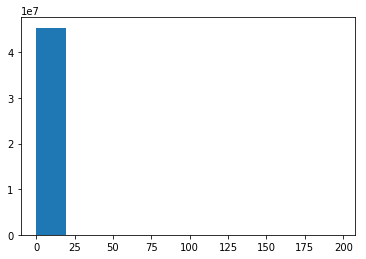

In [632]:
plt.hist(intensities)

In [633]:
np.cumsum(intensities)

array([-2.80254722e-01, -5.23682252e-01, -7.61403143e-01, ...,
        3.36098524e+07,  3.36100345e+07,  3.36102325e+07])

In [12]:
spec1 = 1
spec2 = 17894


map_1 = tupel2map(parser.getspectrum(spec1))
map_2 = tupel2map(parser.getspectrum(spec2))

map1MZ = set([x for x in map_1])
map2MZ = set([x for x in map_2])

print(len(map1MZ), len(map2MZ), len(map1MZ.intersection(map2MZ)))

unionMZ = set(map1MZ.union(map2MZ))

for x in unionMZ:
    
    if not (x in map_1 and x in map_2):
        print("Missing in 1 Map", x, x in map_1, x in map_2)



17900 17900 17900


In [19]:
pixel_map = dict()
for x in range(617,  665):
    for y in range(210, 265):
        try:
            idx = parser.coordinates.index((x, y, 1))
            spec_map = tupel2map(parser.getspectrum(idx))
            pixel_map[idx] = (spec_map, get_peaks(spec_map))
        except:
            print(f"({x}, {y}, 1) is not in list.")

(617, 210, 1) is not in list.
(617, 211, 1) is not in list.
(617, 212, 1) is not in list.
(617, 213, 1) is not in list.
(617, 214, 1) is not in list.
(617, 215, 1) is not in list.
(617, 216, 1) is not in list.
(617, 217, 1) is not in list.
(617, 218, 1) is not in list.
(617, 219, 1) is not in list.
(617, 220, 1) is not in list.
(617, 221, 1) is not in list.
(617, 222, 1) is not in list.
(617, 223, 1) is not in list.
(617, 224, 1) is not in list.
(617, 225, 1) is not in list.
(617, 226, 1) is not in list.
(617, 227, 1) is not in list.
(617, 228, 1) is not in list.
(617, 229, 1) is not in list.
(617, 230, 1) is not in list.
(617, 231, 1) is not in list.
(617, 232, 1) is not in list.
(617, 233, 1) is not in list.
(617, 234, 1) is not in list.
(617, 235, 1) is not in list.
(617, 236, 1) is not in list.
(617, 237, 1) is not in list.
(617, 238, 1) is not in list.
(617, 239, 1) is not in list.
(617, 240, 1) is not in list.
(617, 241, 1) is not in list.
(617, 242, 1) is not in list.
(617, 243,

In [68]:
ids = list(pixel_map.keys())
print(len(ids))
matrix2 = np.zeros((len(ids), len(ids)))
for i in range(len(ids)):
    print(i)
    for j in range(i, len(ids)):
        tmp = similarity(ids[i], ids[j], pixel_map)
        matrix2[i, j] = matrix2[j, i] = tmp

2538
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


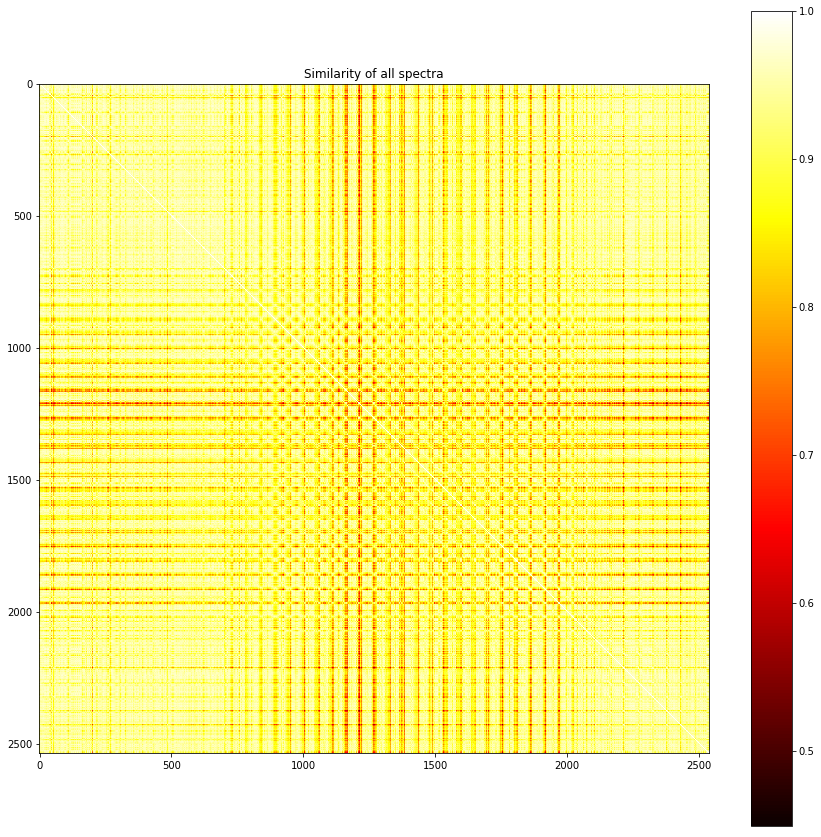

In [104]:
plt.figure(figsize=(15, 15))
tmp2 = matrix2
plt.imshow(matrix2, cmap='hot', interpolation='nearest')
plt.title('Similarity of all spectra')
plt.colorbar()
plt.savefig('all_sim.png')

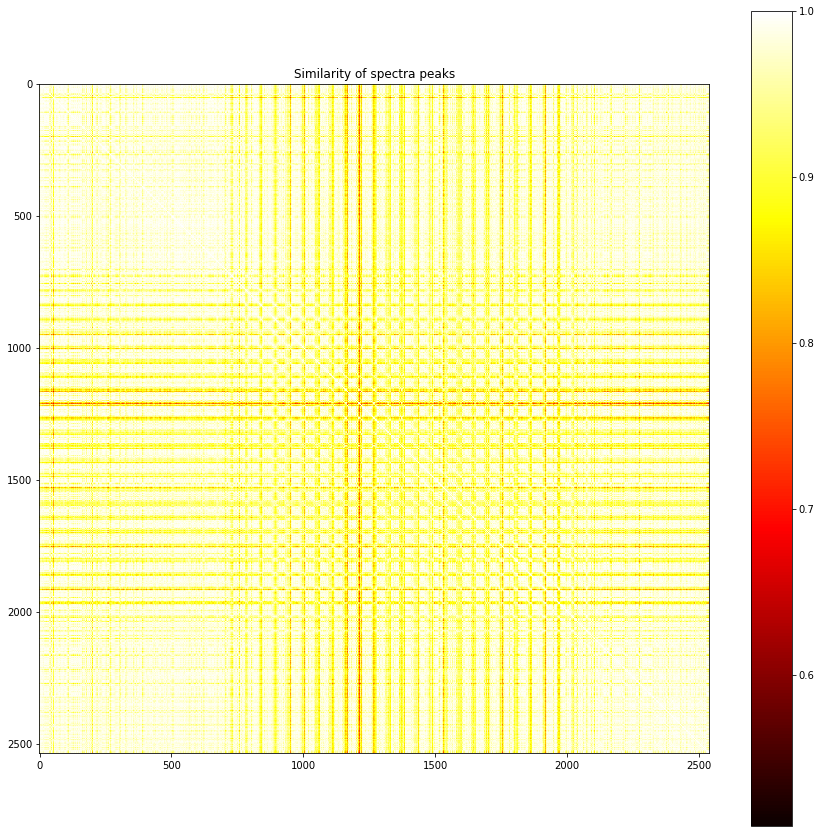

In [105]:
plt.figure(figsize=(15, 15))
tmp = matrix
plt.imshow(matrix, cmap='hot', interpolation='nearest')
plt.title('Similarity of spectra peaks')
plt.colorbar()
plt.savefig('peaks_sim.png')

Text(0.5, 1.0, 'Similarity of all peaks')

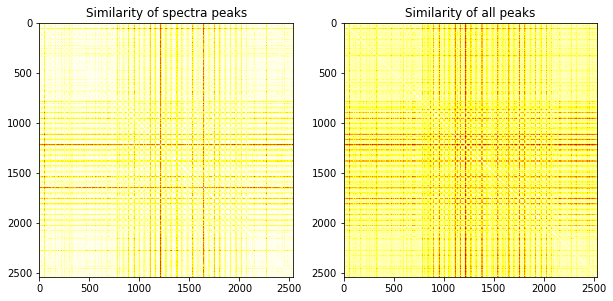

In [438]:
fig = plt.figure(figsize=(10, 20))
fig.add_subplot(1,2,1)
plt.imshow(matrix, cmap='hot', interpolation='nearest')
plt.title('Similarity of spectra peaks')
fig.add_subplot(1,2,2)
plt.imshow(matrix2, cmap='hot', interpolation='nearest')
plt.title('Similarity of all peaks')

In [52]:
X = [640,641,642, 643]#range(640,645)
X2 = [644, 645, 646, 647] #range(640, 645)
a = 0

Y = [240, 241, 242, 243]#range(240, 245)
Y2 = [244, 245, 246, 247]#range(240, 245)
test2 = np.zeros((16, 16))
for x in X:
    print(x)
    for y in Y:
        try:
            idx = parser.coordinates.index((x,y,1))
        except:
            idx = -1
        b = 0    
        if not idx == -1:
            for x2 in X2:
                for y2 in Y2:
                    try:
                        idx2 = parser.coordinates.index((x2, y2, 1))
                    except:
                        idx2 = -1
                    if not idx2 == -1:
                        tmp = similarity(idx, idx2)
                        test2[a, b] = test2[b, a] = tmp
                    b += 1
        a += 1
                
print(a, b)

640
641
642
643
16 16


In [25]:
import _pickle as pickle

spectraMapFile = open("spectraFile.pickle","wb")
pickle.dump(pixel_map, spectraMapFile)

In [107]:
import _pickle as pickle

peaksFile = open("peaksFile.pickle","wb")
pickle.dump(matrix, peaksFile)

In [108]:
file = open("allFile.pickle","wb")
pickle.dump(matrix2, file)

In [ ]:
spectraMapFile = open("spectraFile.pickle","rb")
pmap = pickle.load(spectraMapFile)

In [445]:
similarity(12775, 12776, pixel_map)

0.9608013785655237

In [439]:
def similarity(id1, id2, id_map):
    map_1 = id_map[id1][0]
    map_2 = id_map[id2][0]
    
    #Similarity (dot product) of two comlpete spectra
    a = np.array(list(map_1.values()))
    a = a.reshape(1, len(a))
    b = np.array(list(map_2.values()))
    b = b.reshape(1, len(b))
    cos_lib = cosine_similarity(a, b)
    #print("Two comlpete spectra ", cos_lib)
    return(cos_lib[0][0])
    '''
    map_1 = id_map[id1][0]
    map_2 = id_map[id2][0]
    
    peaks_spec1 = id_map[id1][1]
    peaks_spec2 = id_map[id2][1]
    
    mz = list(set().union(peaks_spec1, peaks_spec2))
    
    mz2int1 = [map_1[x] for x in mz]
    mz2int2 = [map_2[x] for x in mz]
    
    #Similarity (dot product) of two united peak-spectra
    a = np.array(mz2int1)
    b = np.array(mz2int2)  
    
    a = a.reshape(1, len(a))
    b = b.reshape(1, len(b))
    cos_lib = cosine_similarity(a, b)
    #print("Two united peak-spectra ",cos_lib)
    return(cos_lib[0][0])
    '''

11624
1424
2538


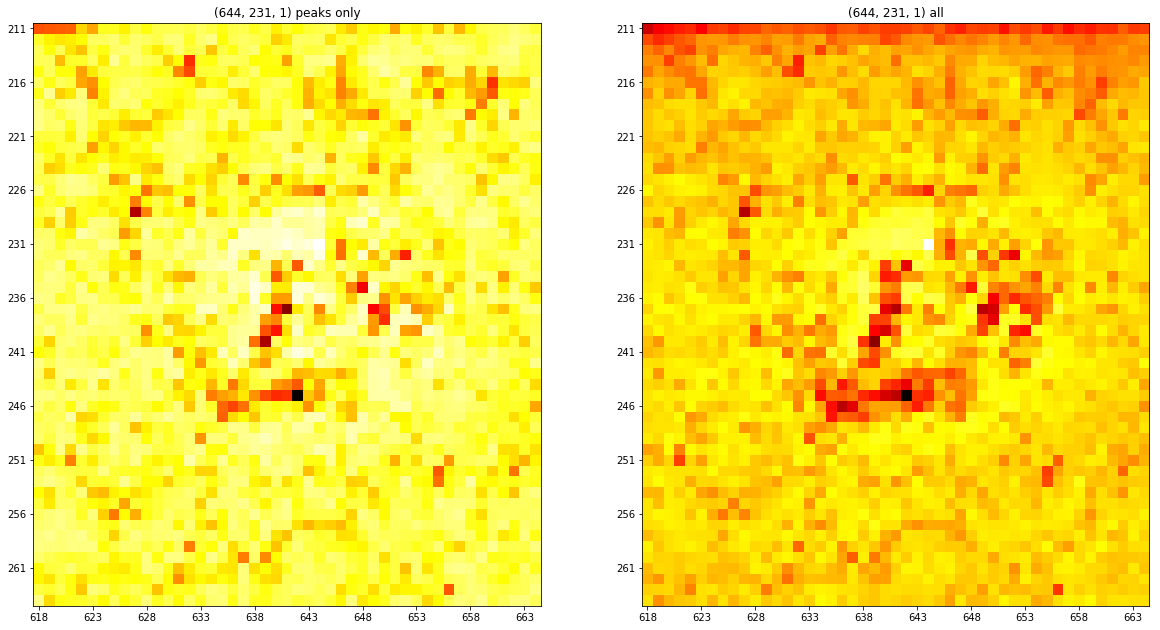

In [446]:
ref1 = parser.coordinates.index((644, 231, 1))
print(ref1)

ids = list(pixel_map.keys())
ref1_id = ids.index(ref1)
print(ref1_id)

print(len(matrix[ref1_id]))
image644_231 = np.zeros((265-211, 665-618))
image644_231_2 = np.zeros((265-211, 665-618))
for i in ids:
    image644_231[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = matrix[ref1_id][ids.index(i)]
    image644_231_2[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = matrix2[ref1_id][ids.index(i)]
fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(image644_231, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('(644, 231, 1) peaks only')
fig.add_subplot(1,2,2)
plt.imshow(image644_231_2, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('(644, 231, 1) all')

plt.savefig('644_231.png')

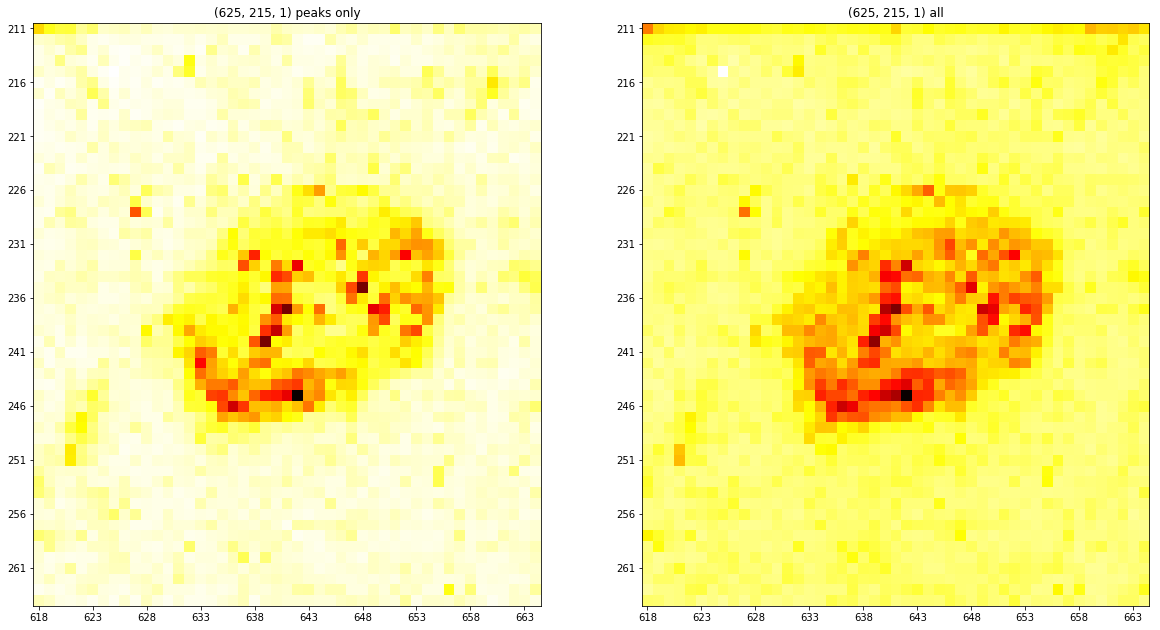

In [447]:
ref2 = parser.coordinates.index((625, 215, 1))

ids = list(pixel_map.keys())
ref2_id = ids.index(ref2)

image625_215 = np.zeros((265-211, 665-618))
image625_215_2 = np.zeros((265-211, 665-618))
for i in ids:
    image625_215[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = matrix[ref2_id][ids.index(i)]
    image625_215_2[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = matrix2[ref2_id][ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(image625_215, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('(625, 215, 1) peaks only')
fig.add_subplot(1,2,2)
plt.imshow(image625_215_2, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('(625, 215, 1) all')

plt.savefig('625_215.png')

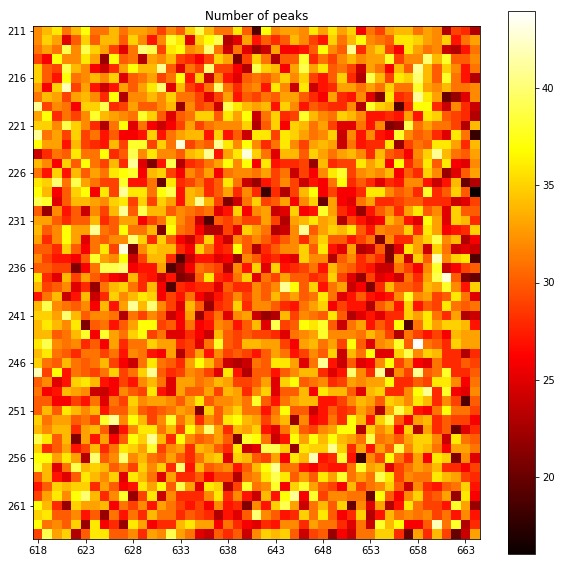

In [448]:
peaks625_215 = np.zeros((265-211, 665-618))

for i in ids:
    peaks625_215[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = len(pixel_map[i][1])
    
plt.figure(figsize=(10, 10))
plt.imshow(peaks625_215, cmap='hot', interpolation='nearest')
plt.title('Number of peaks')

plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))

plt.colorbar()
plt.savefig('npeaks.png')

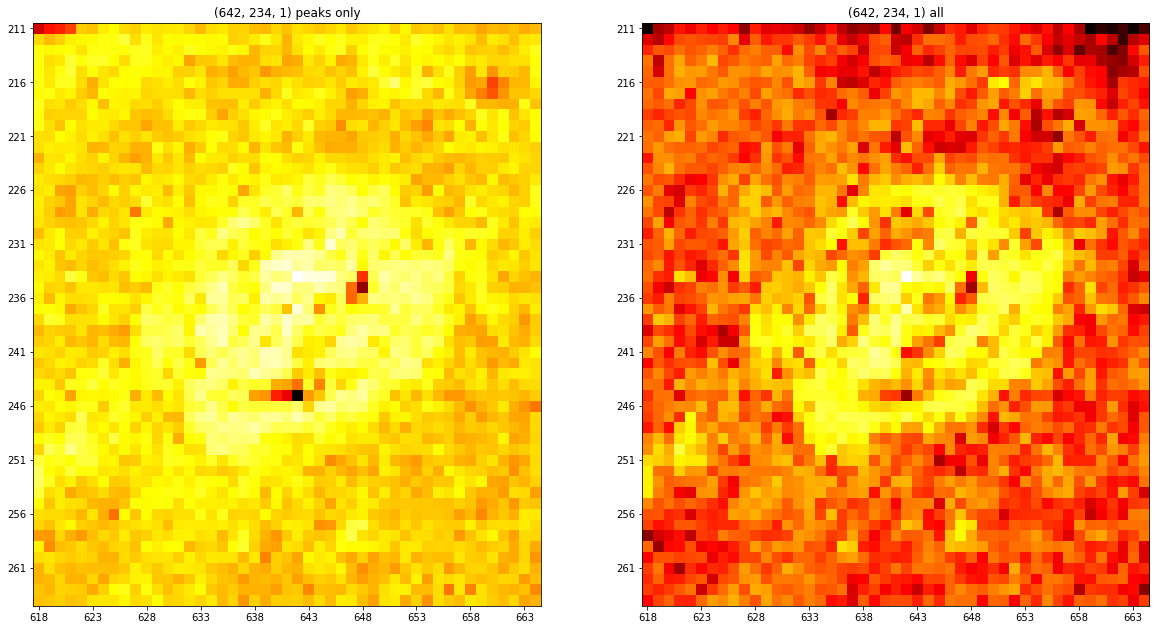

In [449]:
ref3 = parser.coordinates.index((642, 234, 1))

ids = list(pixel_map.keys())
ref3_id = ids.index(ref3)

image642_234 = np.zeros((265-211, 665-618))
image642_234_2 = np.zeros((265-211, 665-618))
for i in ids:
    image642_234[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = matrix[ref3_id][ids.index(i)]
    image642_234_2[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = matrix2[ref3_id][ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(image642_234, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('(642, 234, 1) peaks only')
fig.add_subplot(1,2,2)
plt.imshow(image642_234_2, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('(642, 234, 1) all')

plt.savefig('642_234.png')

In [450]:
from sklearn.cluster import KMeans
kmeans_all = KMeans(n_clusters=3, random_state=0).fit(matrix2)
kmeans_peaks = KMeans(n_clusters=3, random_state=0).fit(matrix)

Text(0.5, 1.0, '3 clusters K means all')

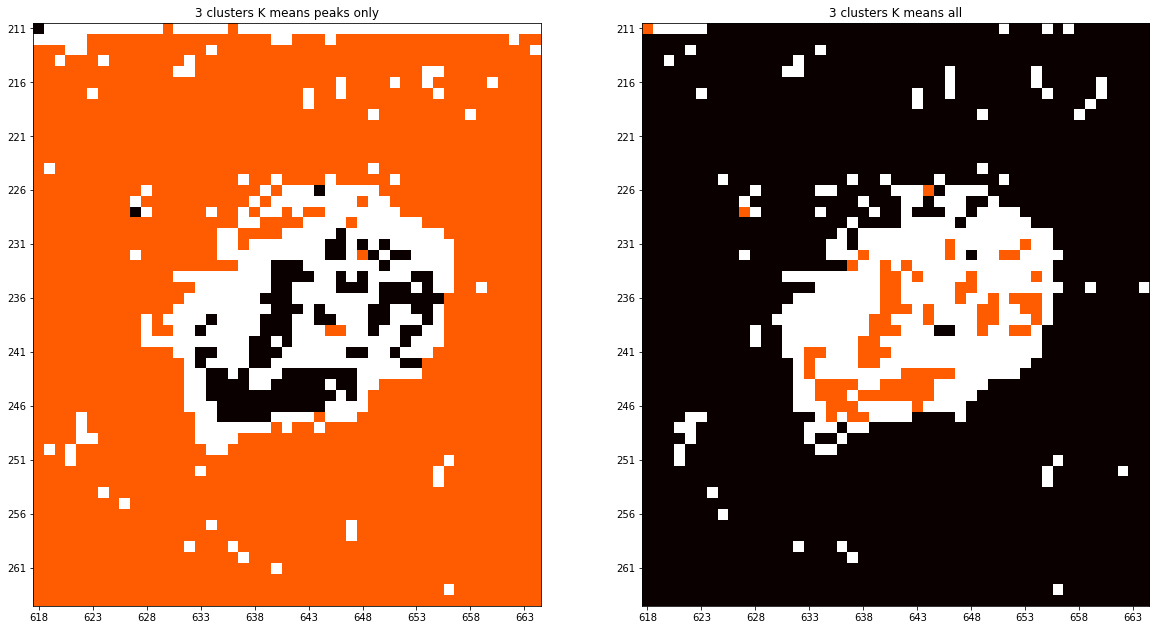

In [451]:
image_kmeans_all = np.zeros((265-211, 665-618))
image_kmeans_peaks = np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_kmeans_all[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = kmeans_all.labels_[ids.index(i)]
    image_kmeans_peaks[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = kmeans_peaks.labels_[ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(image_kmeans_all, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('3 clusters K means peaks only')
fig.add_subplot(1,2,2)
plt.imshow(image_kmeans_peaks, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('3 clusters K means all')

Text(0.5, 1.0, 'SpectralClustering(3) all')

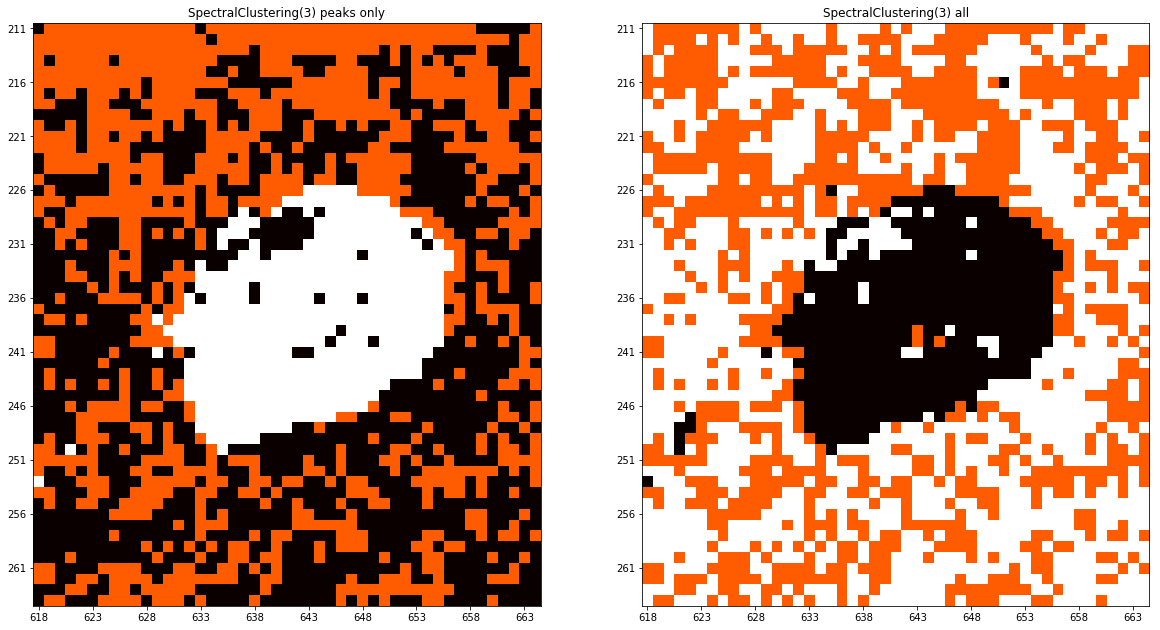

In [470]:
from sklearn.cluster import SpectralClustering
sp1 = SpectralClustering(3, affinity='precomputed', n_init=10).fit_predict(matrix)
sp2 = SpectralClustering(3, affinity='precomputed', n_init=10).fit_predict(matrix2)
image_sp_all = np.zeros((265-211, 665-618))
image_sp_peaks = np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_sp_all[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = sp2[ids.index(i)]
    image_sp_peaks[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = sp1[ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(image_sp_all, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('SpectralClustering(3) peaks only')
fig.add_subplot(1,2,2)
plt.imshow(image_sp_peaks, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('SpectralClustering(3) all')

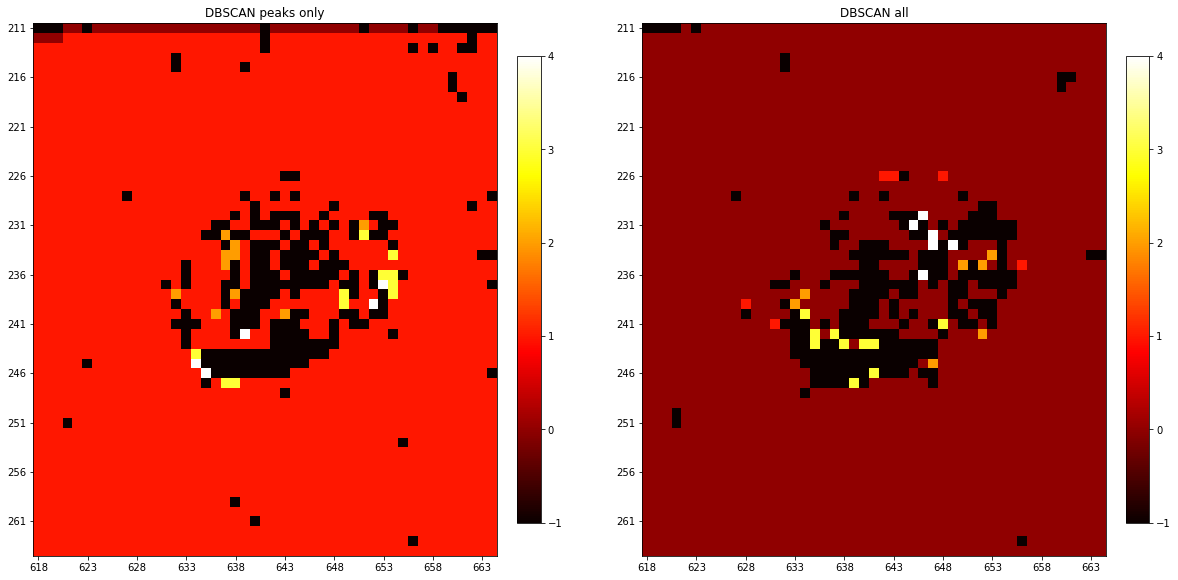

In [476]:
from sklearn.cluster import DBSCAN
dbscan1 = DBSCAN().fit(1-matrix)
dbscan2 = DBSCAN().fit(1-matrix2)
image_dbscan_all = np.zeros((265-211, 665-618))
image_dbscan_peaks = np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_dbscan_all[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = dbscan2.labels_[ids.index(i)]
    image_dbscan_peaks[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = dbscan1.labels_[ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
im = plt.imshow(image_dbscan_all, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('DBSCAN peaks only')
plt.colorbar(im, fraction=0.046, pad=0.04)
fig.add_subplot(1,2,2)
im = plt.imshow(image_dbscan_peaks, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('DBSCAN all')
plt.colorbar(im, fraction=0.046, pad=0.04)

In [477]:
import random

def cluster(distances, k=3):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)
   
    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point. 
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters, curr_medoids

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    clusters[medoids] = medoids
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

In [478]:
cluster(matrix2, 3)[0]

array([   0, 1330, 1330, ..., 1330, 1330, 1330])

Text(0.5, 1.0, 'K medoid all')

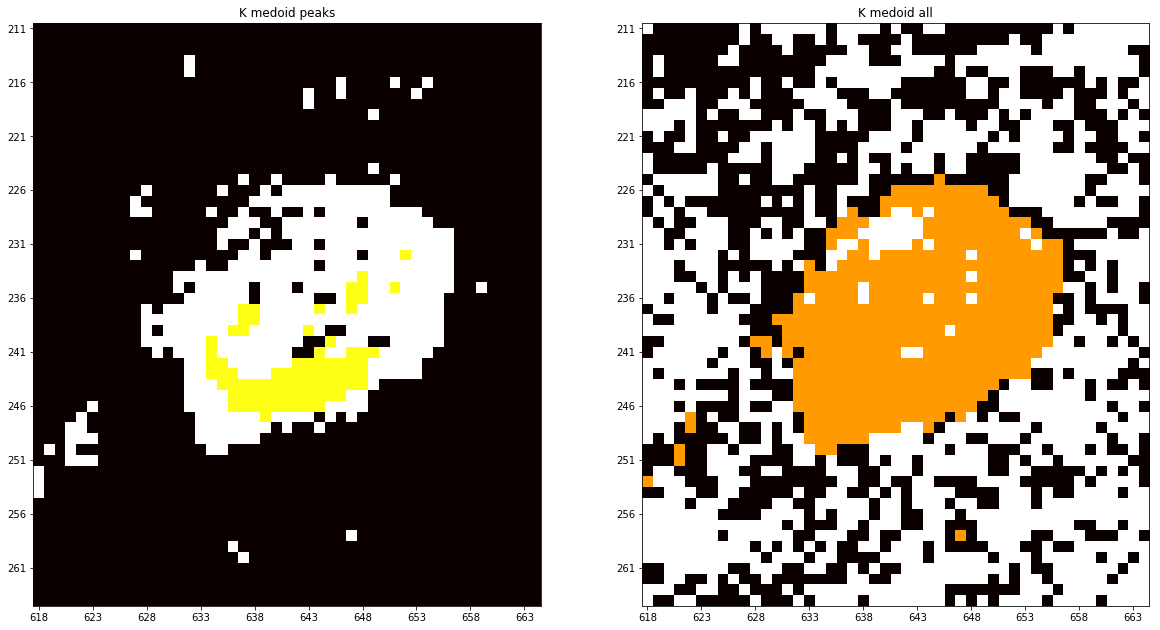

In [483]:
kmedoid = cluster(1-matrix, 3) #Distance Matrix!!!
kmedoid2 = cluster(1-matrix2, 3) #Distance Matrix!!!
image_kmedoid = np.zeros((265-211, 665-618))
image_kmedoid_all = np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_kmedoid[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = kmedoid[0][ids.index(i)]
    image_kmedoid_all[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = kmedoid2[0][ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(image_kmedoid, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('K medoid peaks')
fig.add_subplot(1,2,2)
plt.imshow(image_kmedoid_all, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('K medoid all')

In [481]:
from Bio import Cluster
Cluster.kmedoids(matrix2, nclusters=3, npass=1, initialid=None)

(array([1330, 1330, 1330, ..., 1330, 1330, 1330], dtype=int32),
 1569.7013276940074,
 1)

Text(0.5, 1.0, 'K medoid all')

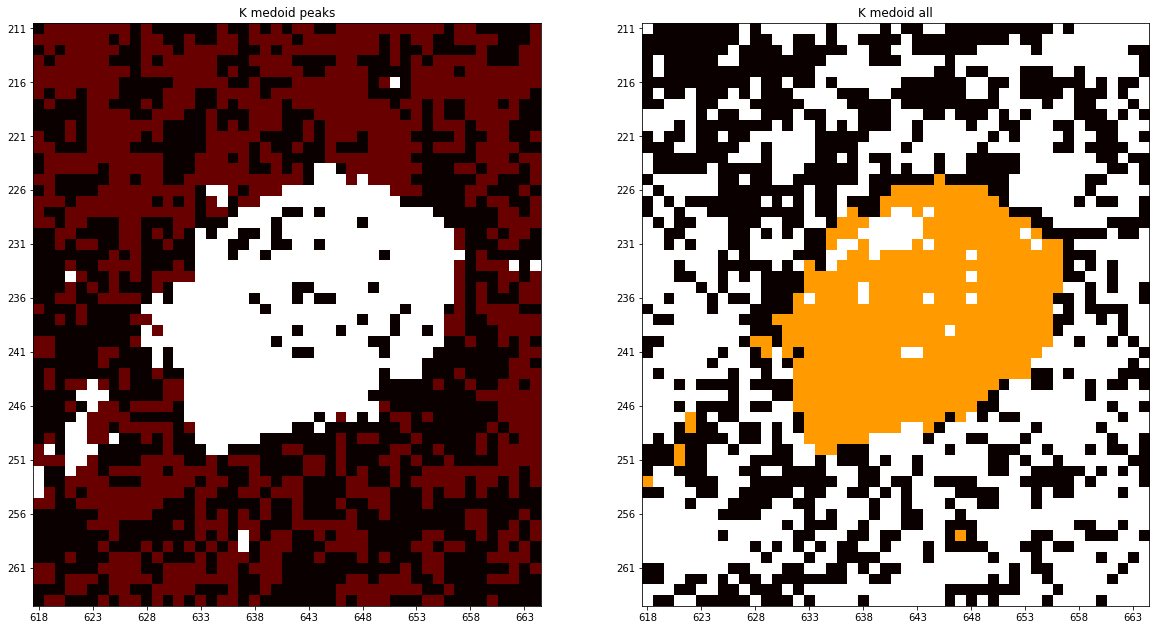

In [490]:
kmedoid = Cluster.kmedoids(1-matrix, nclusters=3, npass=1, initialid=None) #Distance Matrix!!!
kmedoid2 = Cluster.kmedoids(1-matrix2, nclusters=3, npass=1, initialid=None) #Distance Matrix!!!
image_kmedoid = np.zeros((265-211, 665-618))
image_kmedoid_all = np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_kmedoid[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = kmedoid[0][ids.index(i)]
    image_kmedoid_all[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = kmedoid2[0][ids.index(i)]
'''
plt.figure(figsize=(20, 20))
plt.imshow(image_kmedoid, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5), fontsize=20)
plt.yticks(range(0,265-211,5), np.arange(211,265,5), fontsize=20)
plt.title('K-medoid clusters for peaks distances', fontsize=20)
plt.savefig('kmedoid_peaks.png')
plt.imshow(image_kmedoid_all, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5), fontsize=20)
plt.yticks(range(0,265-211,5), np.arange(211,265,5), fontsize=20)
plt.title('K-medoid clusters', fontsize=20)
plt.savefig('kmedoid_all.png')
'''
fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(image_kmedoid, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('K medoid peaks')
fig.add_subplot(1,2,2)
plt.imshow(image_kmedoid_all, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('K medoid all')

In [669]:
#Markus
def nested_item(depth, value):
    if depth <= 1:
        return [value]
    else:
        return [nested_item(depth - 1, value)]


def nested_list(n):
    """Generate a nested list where the i'th item is at depth i."""
    lis = []
    for i in range(n):
        if i == 0:
            lis.append(i)
        else:
            lis.append(nested_item(i, i))
    return lis


def flatten(lis):
    """Given a list, possibly nested to any level, return it flattened."""
    new_lis = []
    for item in lis:
        if type(item) in [list, tuple]:
            new_lis.extend(flatten(item))
        else:
            new_lis.append(item)
    return new_lis


class MatrixClust:

    def __init__(self, M, labels):
        self.matrix = M
        self.labels = labels

    def cluster(self, mode='UPGMA'):

        nLabels = [x for x in self.labels]
        nMatrix = {}
        origMatrix = {}

        for i in range(0, len(self.matrix)):

            for j in range(0, len(self.matrix[i])):
                nMatrix[((nLabels[i],), (nLabels[j],))] = self.matrix[i][j]
                nMatrix[((nLabels[j],), (nLabels[i],))] = self.matrix[i][j]

        for x in nMatrix:
            origMatrix[x] = nMatrix[x]

        treeLabel = ""

        endClusters = 1

        if mode == "NEIGHBOR":
            endClusters = 2

        while len(self.matrixLabels(nMatrix)) > endClusters:

            # find lowest element positions

            clustA = None
            clustB = None

            nLabels = sorted(list(self.matrixLabels(nMatrix)), key=lambda x: str(x))
            #print(nLabels)
            #print(self.to_matrix(nMatrix, nLabels))

            if mode == "NEIGHBOR":

                allLabels = self.matrixLabels(nMatrix)
                aElems = [x for x in nMatrix.items()]

                r_iMap = {}

                # calculate r_i
                for label in allLabels:
                    labelElems = [x for x in aElems if x[0][0] == label or x[0][1] == label]
                    labelsSum = sum([x[1] for x in labelElems]) / 2.0
                    r_iMap[label] = labelsSum

                mijMat = {}

                for elem in aElems:
                    lLabel = elem[0][0]
                    rLabel = elem[0][1]

                    mijMat[(lLabel, rLabel)] = elem[1] - ((r_iMap[lLabel] + r_iMap[rLabel]) / (len(allLabels) - 2))

                #print(r_iMap)
                #print(mijMat)
                mijLabels = sorted(self.matrixLabels(mijMat), key=lambda x: str(x))
                #print("mij", mijLabels)
                #print("mij", self.to_matrix(mijMat, mijLabels))

                sElems = sorted([x for x in mijMat.items()], key=lambda x: x[1])

                minElem = sElems[0]
                clustA = minElem[0][0]
                clustB = minElem[0][1]

            else:
                sElems = sorted([x for x in nMatrix.items()], key=lambda x: x[1])
                minElem = sElems[0]

                clustA = minElem[0][0]
                clustB = minElem[0][1]

            #print("Merging", clustA, clustB)

            if clustA == None or clustB == None:
                exit(-1)

            sElems = sorted([x for x in nMatrix.items()], key=lambda x: x[1])

            # merge clusters
            newCluster = tuple(sorted(flatten(clustA) + flatten(clustB)))

            # copy unchanged elems
            newElems = []
            otherLabels = set()

            for elem in sElems:

                cLabels = elem[0]

                lLabelMerging = cLabels[0] in [clustA, clustB]
                rLabelMerging = cLabels[1] in [clustA, clustB]

                if lLabelMerging and rLabelMerging:
                    continue
                elif lLabelMerging:
                    otherLabels.add(cLabels[1])
                    continue
                elif rLabelMerging:
                    otherLabels.add(cLabels[0])
                    continue

                newElems.append(elem)

            newCluster = (clustA, clustB)

            if len(otherLabels) == 0:
                break

            # calculate new distances
            for label in otherLabels:

                dist = 0

                label = tuple(label)

                distA = self.matrixDistance(nMatrix, clustA, label)
                distB = self.matrixDistance(nMatrix, clustB, label)

                if mode == 'UPGMA':

                    dist += len(clustA) * distA
                    dist += len(clustB) * distB

                    dist = dist / (len(clustA) + len(clustB))

                elif mode == 'SINGLE':

                    dist = min([distA, distB])


                elif mode == 'COMPLETE':

                    dist = max([distA, distB])

                elif mode == 'NEIGHBOR':

                    distClust = self.matrixDistance(nMatrix, clustA, clustB)
                    dist = (distA + distB - distClust) / 2.0

                newElems.append(((label, newCluster), dist))
                newElems.append(((newCluster, label), dist))

            # newElems to nMatrix

            nMatrix = {}
            for x in newElems:
                nMatrix[x[0]] = x[1]

        nLabels = sorted(list(self.matrixLabels(nMatrix)), key=lambda x: str(x))
        #print(nLabels)
        #print(self.to_matrix(nMatrix, nLabels))
        # Return the final label
        #return str(tuple(self.matrixLabels(nMatrix)))
        return tuple(self.matrixLabels(nMatrix))

    def to_matrix(self, nmatrix, nlabels):

        nlabels = list(nlabels)
        mat = np.zeros((len(nlabels), len(nlabels)))

        for x in nmatrix:
            li = nlabels.index(x[0])
            ri = nlabels.index(x[1])

            mat[li][ri] = nmatrix[x]

        return mat

    def matrixDistance(self, nmatrix, clustA, clustB, default=None):

        # clustA = tuple(clustA)
        # clustB = tuple(clustB)

        return nmatrix.get((clustA, clustB), nmatrix.get((clustB, clustA), default))

    def matrixLabels(self, nmatrix):

        slabels = set()

        for x in nmatrix:
            slabels.add(x[0])
            slabels.add(x[1])

        return slabels

In [803]:
M_labels = range(6)

M = to_triang(A)

clustor = MatrixClust( M, M_labels )

In [804]:
res = clustor.cluster(mode="NEIGHBOR")
print(res)

(((2,), (0,)), ((1,), ((4,), (3,))))


In [805]:
l = list()
def re_add(tup):
    if len(tup)==1:
        l.append(tup[0])
    else:
        re_add(tup[0])
        re_add(tup[1])
    return list(set(l))

In [806]:
cluster1 = re_add(res[0])
l = list()
cluster2 = re_add(res[1])

In [807]:
print(cluster1, cluster2)

[0, 2] [1, 3, 4]


In [808]:
visual = np.zeros((len(M_labels), len(M_labels)))
for i in cluster2:
    for j in cluster2:
        visual[i][j] = 1

In [809]:
visual

array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 1., 0.],
       [0., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [799]:
A = np.array([[1, 4, 5, 12, 9], 
              [-5, 8, 9, 0, 4],
              [-6, 7, 11, 19, 1],
              [1, 4, 5, 1, 2, 9], 
              [-5, 8, 9, 0, 6]])

In [800]:
to_triang(A)

[[], [-5], [-6, 7], [1, 4, 5], [-5, 8, 9, 0]]

In [801]:
def to_triang(A):
    new_A = list()
    for i in range(A.shape[0]):
        new_A.append(A[i][:i])
    return new_A

In [810]:
new_matrix = to_triang(matrix)
new_matrix2 = to_triang(matrix2)

In [811]:
matrix.shape

(2538, 2538)

In [812]:
M_labels = range(matrix.shape[0])
clustor = MatrixClust( new_matrix, M_labels )

In [ ]:
res = clustor.cluster(mode="NEIGHBOR")